In [1]:
import scipy.io
import numpy as np, h5py
import matplotlib.pyplot as plt
import copy
import pandas as pd
import pickle
%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams['figure.dpi']=150
rcParams['lines.linewidth']=1
rcParams['axes.grid']=True
rcParams['axes.facecolor']='#FFFFFF'
rcParams['font.size']=14
rcParams['patch.edgecolor']='none'

In [3]:
# fix random seed for reproducibility
seed = 8
np.random.seed(seed)

In [4]:
def readScan(scan):
    # We read the file saved in Matlab. There is only one variable in the file called scansMini
    data = h5py.File(scan, 'r')
    Xscans=data.get('scansMini')
    # We have to get the values into the right format (subjects, dim1, dim2, dim3, channels)
    X=copy.copy(Xscans.value)
    X=np.expand_dims(X,4)
    X1=np.rollaxis(X,3)
    return X1

In [5]:
X1=readScan('scansTrainFold1/scansMini1.mat')
X2=readScan('scansTrainFold1/scansMini2.mat')
X3=readScan('scansTrainFold1/scansMini3.mat')
X4=readScan('scansTrainFold1/scansMini4.mat')
X5=readScan('scansTrainFold1/scansMini5.mat')

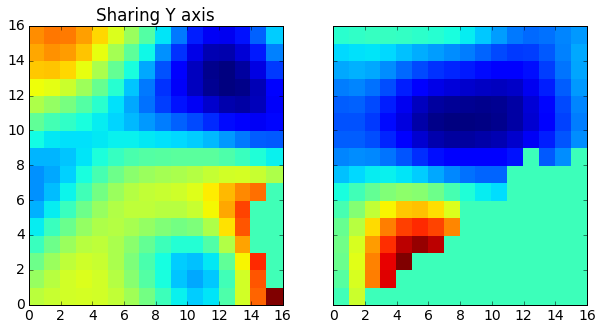

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pcolor((X1[10,:,:,0,0]))
ax1.set_title('Sharing Y axis')
ax2.pcolor((X2[10,:,:,0,0]))

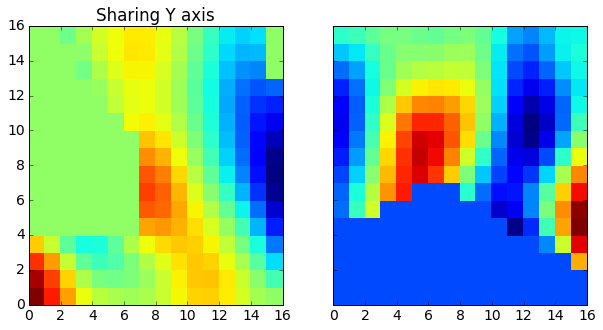

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pcolor((X3[80,:,:,0,0]))
ax1.set_title('Sharing Y axis')
ax2.pcolor((X4[80,:,:,0,0]))

In [8]:
names=pd.read_csv('scansTrainFold1/scanNames.csv')
namesDF=pd.DataFrame(names)
y=namesDF.label.values.astype(int)

In [9]:
X1.shape

(171, 16, 16, 16, 1)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Merge
from keras.layers.convolutional import Convolution3D
from keras.layers.pooling import MaxPooling3D
from keras.layers.core import Dense, Flatten
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from keras.callbacks import EarlyStopping
import time

Using TensorFlow backend.


In [120]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

---

In [107]:
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-05)#1e-04

In [108]:
final_model.reset_states()
model1.reset_states()
model2.reset_states()
model3.reset_states()
model4.reset_states()
model5.reset_states()

In [109]:
model1=Sequential()
model1.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))
model1.add(Flatten())
model1.add(Dense(20, init='glorot_normal', activation='tanh'))

In [110]:
model2=Sequential()
model2.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))
model2.add(Flatten())
model2.add(Dense(20, init='glorot_normal', activation='tanh'))

In [111]:
model3=Sequential()
model3.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))
model3.add(Flatten())
model3.add(Dense(20, init='glorot_normal', activation='tanh'))

In [112]:
model4=Sequential()
model4.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))
model4.add(Flatten())
model4.add(Dense(20, init='glorot_normal', activation='tanh'))

In [113]:
model5=Sequential()
model5.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))
model5.add(Flatten())
model5.add(Dense(20, init='glorot_normal', activation='tanh'))

In [114]:
merged = Merge([model1, model2, model3, model4, model5], mode='concat')
final_model = Sequential()
final_model.add(merged)
final_model.add(Dense(10, init='uniform', activation='tanh'))
final_model.add(Dense(1, init='uniform', activation='tanh'))
final_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [115]:
import keras.backend as K
K.get_value(adam.lr)

0.001

In [ ]:
# Fit the model
t0 = time.time()
history=final_model.fit([X1, X2, X3, X4, X5], y, validation_split=0.2, nb_epoch=150, batch_size=16,verbose=0)#callbacks=[callbacks]
t1 = time.time()
print (t1-t0)/60/60

In [94]:
# https://github.com/fchollet/keras/issues/888
# https://github.com/fchollet/keras/issues/898
acc_train=[]
loss_train=[]
acc_val=[]
loss_val=[]
all_lr=[]
t0 = time.time()
for iteration in np.linspace(0,149,150):
    K.set_value(adam.lr, 0.99 * K.get_value(adam.lr))
    history=final_model.fit([X1, X2, X3, X4, X5], y, validation_split=0.2, nb_epoch=1, batch_size=16,verbose=0)
    acc_train.append(history.history['acc'])
    acc_val.append(history.history['val_acc'])
    loss_train.append(history.history['loss'])
    loss_val.append(history.history['val_loss'])
    all_lr.append(K.get_value(adam.lr))
t1 = time.time()
print (t1-t0)/60/60

5.04627318303


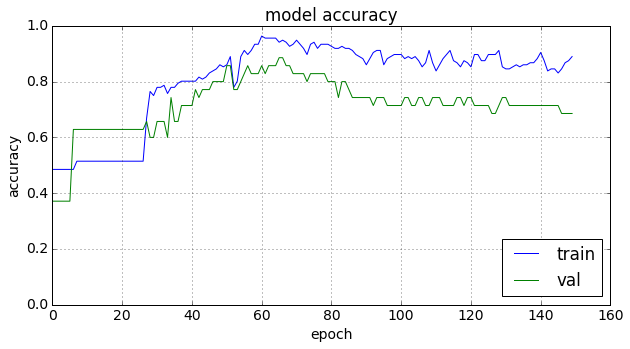

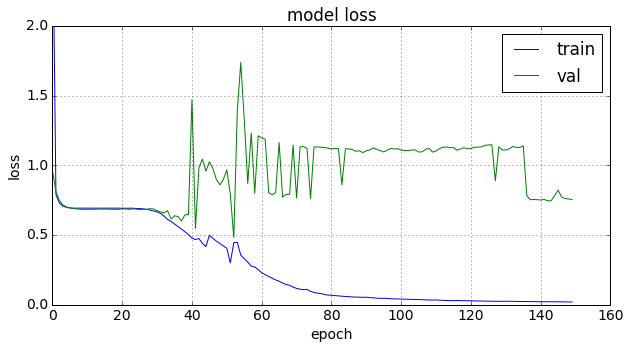

In [95]:
#summarize history for accuracy
fig=plt.figure()
plt.plot(acc_train)
plt.plot(acc_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='lower right')
plt.ylim([0, 1])
plt.show()
# summarize history for accuracy
plt.plot(loss_train)
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.ylim([0, 2])
plt.show()

In [96]:
K.get_value(adam.lr)

0.0002214519

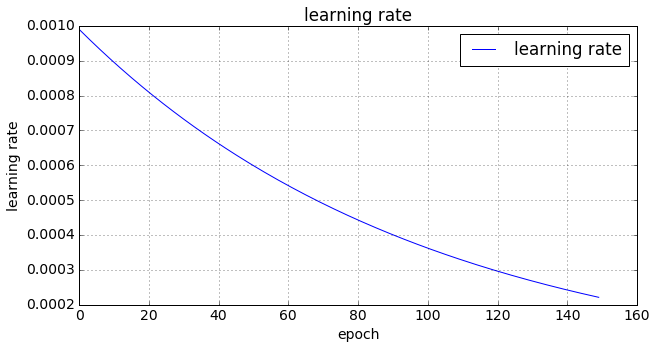

In [99]:
fig=plt.figure()
plt.plot(all_lr)
plt.title('learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['learning rate'], loc='upper right')
plt.show()

In [100]:
final_model.save('m502a.h5')

In [101]:
X1test=readScan('scansTestFold1/fold1scansMini1Out.mat')
X2test=readScan('scansTestFold1/fold1scansMini2Out.mat')
X3test=readScan('scansTestFold1/fold1scansMini3Out.mat')
X4test=readScan('scansTestFold1/fold1scansMini4Out.mat')
X5test=readScan('scansTestFold1/fold1scansMini5Out.mat')

In [102]:
y_pred=final_model.predict([X1test, X2test, X3test, X4test, X5test])

In [103]:
y_predC=final_model.predict_classes([X1test, X2test, X3test, X4test, X5test])
y_predC=np.squeeze(y_predC)

41/41 [==============================] - 3s     


In [104]:
namesTest=pd.read_csv('scansTestFold1/scansNamesTestFold1.csv')
namesTestDF=pd.DataFrame(namesTest)
y_true=namesTestDF.label.values.astype(int)

In [105]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score

In [106]:
print accuracy_score(y_true,y_predC)
confusion_matrix(y_true,y_predC)

0.682926829268


array([[ 8, 11],
       [ 2, 20]])

---

---

---

In [ ]:
from keras.utils.np_utils import to_categorical
y_binary = to_categorical(ysq)

In [ ]:
def baseline_model():
    model=Sequential()
    model.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, init='uniform', activation='tanh'))
    model.add(Dense(1, init='uniform', activation='tanh'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=10, verbose=0)
kfold = KFold(n=len(X), n_folds=8, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, ysq, cv=kfold)
print results
print results.mean()

---

---

---

### Model 18 demean data -> Model501
model1=Sequential()   
model1.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model1.add(Flatten())   
model1.add(Dense(20, init='glorot_normal', activation='tanh'))   

model2=Sequential()   
model2.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model2.add(Flatten())   
model2.add(Dense(20, init='glorot_normal', activation='tanh'))   

model3=Sequential()   
model3.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model3.add(Flatten())   
model3.add(Dense(20, init='glorot_normal', activation='tanh'))   

model4=Sequential()   
model4.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model4.add(Flatten())   
model4.add(Dense(20, init='glorot_normal', activation='tanh'))   

model5=Sequential()   
model5.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model5.add(Flatten())   
model5.add(Dense(20, init='glorot_normal', activation='tanh'))   

merged = Merge([model1, model2, model3, model4, model5], mode='concat')   
final_model = Sequential()   
final_model.add(merged)   
final_model.add(Dense(10, init='uniform', activation='tanh'))   
final_model.add(Dense(1, init='uniform', activation='tanh'))   
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

history=final_model.fit([X1, X2, X3, X4, X5], y, validation_split=0.2, nb_epoch=100, batch_size=16,verbose=0)#callbacks=[callbacks]

### Model 18 demean data -> Model501
model1=Sequential()   
model1.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model1.add(Flatten())   
model1.add(Dense(20, init='glorot_normal', activation='tanh'))   

model2=Sequential()   
model2.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model2.add(Flatten())   
model2.add(Dense(20, init='glorot_normal', activation='tanh'))   

model3=Sequential()   
model3.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model3.add(Flatten())   
model3.add(Dense(20, init='glorot_normal', activation='tanh'))   

model4=Sequential()   
model4.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model4.add(Flatten())   
model4.add(Dense(20, init='glorot_normal', activation='tanh'))   

model5=Sequential()   
model5.add(Convolution3D(10, 3, 3, 3, input_shape=(16, 16, 16,1), border_mode='valid', activation='relu'))   
model5.add(Flatten())   
model5.add(Dense(20, init='glorot_normal', activation='tanh'))   

merged = Merge([model1, model2, model3, model4, model5], mode='concat')   
final_model = Sequential()   
final_model.add(merged)   
final_model.add(Dense(10, init='uniform', activation='tanh'))   
final_model.add(Dense(1, init='uniform', activation='tanh'))   
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

history=final_model.fit([X1, X2, X3, X4, X5], y, validation_split=0.2, nb_epoch=100, batch_size=16,verbose=0)#callbacks=[callbacks]

In [ ]:
# Fit the model
t0 = time.time()
history=final_model.fit([X1, X2, X3, X4, X5], y, validation_split=0.2, nb_epoch=120, batch_size=16,verbose=0)#callbacks=[callbacks]
t1 = time.time()
print (t1-t0)/60/60